<a href="https://colab.research.google.com/github/JustSerhii/ling2_sentiment-analysis/blob/main/sentiment_analysis_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lab 2
###BERT FINE-TUNING
###drug review dataset

##Опис задачі
Реалізовано sentiment analysis з використанням попередньо натренованої моделі BERT. Основною метою було класифікувати відгуки користувачів про ліки на три категорії: позитивні, середні та негативні залежно від рейтингу.

Модель BERT налаштовано для класифікації текстів через додавання класифікаційного шару, який розрізняє три класи відгуків. Тренування виконувалося на GPU з використанням оптимізатора AdamW та лінійного графіка зміни швидкості навчання. Дані розділено на тренувальну вибірку до 2017 року та тестову вибірку для двох випадків: до 2017 року та за 2017 рік.

In [ ]:
# -*- coding: utf-8 -*-
"""sentiment-analysis_modified.ipynb

Automatically modified as per user requirements.
"""

# This Python 3 environment comes with many helpful analytics libraries installed
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"""## 1: Exploratory Data Analysis and Preprocessing"""

import torch
from tqdm.notebook import tqdm


In [ ]:

# Шляхи до файлів
file_until_2017 = './sample_data/drugsComTrain_raw_until2017.csv'
file_2017 = './sample_data/drugsComTrain_raw_2017.csv'

# Завантаження даних до 2017 року
df = pd.read_csv(file_until_2017, parse_dates=['date'], date_parser=lambda x: pd.to_datetime(x, format='%d-%b-%y'))
df = df[['uniqueID', 'review', 'rating', 'date']]
df.set_index('uniqueID', inplace=True)

df.head()

# Завантаження даних за 2017 рік
df_2017 = pd.read_csv(file_2017, parse_dates=['date'], date_parser=lambda x: pd.to_datetime(x, format='%d-%b-%y'))
df_2017 = df_2017[['uniqueID', 'review', 'rating', 'date']]
df_2017.set_index('uniqueID', inplace=True)

df_2017.head()


<ipython-input-2-9b0c81212756>:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(file_until_2017, parse_dates=['date'], date_parser=lambda x: pd.to_datetime(x, format='%d-%b-%y'))
<ipython-input-2-9b0c81212756>:13: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_2017 = pd.read_csv(file_2017, parse_dates=['date'], date_parser=lambda x: pd.to_datetime(x, format='%d-%b-%y'))


,review,rating,date
uniqueID,,,
165907,"""He pulled out, but he cummed a bit in me. I t...",1,2017-03-07
75612,"""I have taken anti-depressants for years, with...",10,2017-03-09
221320,"""Have a little bit of a lingering cough from a...",4,2017-09-07
81890,"""I have been taking Saxenda since July 2016. ...",9,2017-01-19
48188,"""This drug worked very well for me and cleared...",9,2017-09-22


In [ ]:
import matplotlib.pyplot as plt
# Шляхи до файлів
file_until_2017 = './sample_data/drugsComTrain_raw_until2017.csv'
file_2017 = './sample_data/drugsComTrain_raw_2017.csv'

# Завантаження даних до 2017 року
df = pd.read_csv(file_until_2017, parse_dates=['date'], date_parser=lambda x: pd.to_datetime(x, format='%d-%b-%y'))
df = df[['uniqueID', 'review', 'rating', 'date']]
df.set_index('uniqueID', inplace=True)

df.head()

# Завантаження даних за 2017 рік
df_2017 = pd.read_csv(file_2017, parse_dates=['date'], date_parser=lambda x: pd.to_datetime(x, format='%d-%b-%y'))
df_2017 = df_2017[['uniqueID', 'review', 'rating', 'date']]
df_2017.set_index('uniqueID', inplace=True)

df_2017.head()

# Функція для категоризації рейтингу
def categorize_rating(rating):
    # Якщо рейтинг 8 і більше, відноситься до категорії 'cool'
    if rating >= 8:
        return 'cool'  # Високий рейтинг (8-10)
    # Якщо рейтинг від 5 до 7 включно, відноситься до категорії 'mid'
    elif rating >= 5:
        return 'mid'  # Середній рейтинг (5-7)
    # Якщо рейтинг менше 5, відноситься до категорії 'bad'
    else:
        return 'bad'  # Низький рейтинг (1-4)

# Категоризація рейтингу для основного датасету df
df['rating'] = df['rating'].apply(categorize_rating)

# Категоризація рейтингу для датасету df_2017
df_2017['rating'] = df_2017['rating'].apply(categorize_rating)

# Підрахунок кількості зразків у кожній категорії рейтингу
df['rating'].value_counts()

# Отримання унікальних міток (категорій рейтингу)
possible_labels = df['rating'].unique()

# Створення словника для кодування категорій у числові значення
label_dict = {label: idx for idx, label in enumerate(possible_labels)}

# Кодування категорій рейтингу в числові значення для основного датасету
df['rating'] = df['rating'].map(label_dict)

# Кодування категорій рейтингу в числові значення для датасету df_2017
df_2017['rating'] = df_2017['rating'].map(label_dict)

# Обмеження розміру основного датасету до 10,000 зразків для швидшого тренування
df = df.head(10000)

# Виведення перших 10 рядків для перевірки результату
df.head(10)

<ipython-input-11-1533cccb84c8>:7: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(file_until_2017, parse_dates=['date'], date_parser=lambda x: pd.to_datetime(x, format='%d-%b-%y'))
<ipython-input-11-1533cccb84c8>:14: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_2017 = pd.read_csv(file_2017, parse_dates=['date'], date_parser=lambda x: pd.to_datetime(x, format='%d-%b-%y'))


,review,rating,date
uniqueID,,,
206461,"""It has no side effect, I take it in combinati...",0,2012-05-20
95260,"""My son is halfway through his fourth week of ...",0,2010-04-27
92703,"""I used to take another oral contraceptive, wh...",1,2009-12-14
138000,"""This is my first time using any form of birth...",0,2015-11-03
35696,"""Suboxone has completely turned my life around...",0,2016-11-27
155963,"""2nd day on 5mg started to work with rock hard...",2,2015-11-28
102654,"""Abilify changed my life. There is hope. I was...",0,2015-03-14
74811,""" I Ve had nothing but problems with the Kepp...",2,2016-08-09
48928,"""I had been on the pill for many years. When m...",0,2016-12-08


<ipython-input-12-28c4b10e535c>:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_until_2017 = pd.read_csv(file_until_2017, parse_dates=['date'], date_parser=lambda x: pd.to_datetime(x, format='%d-%b-%y'))


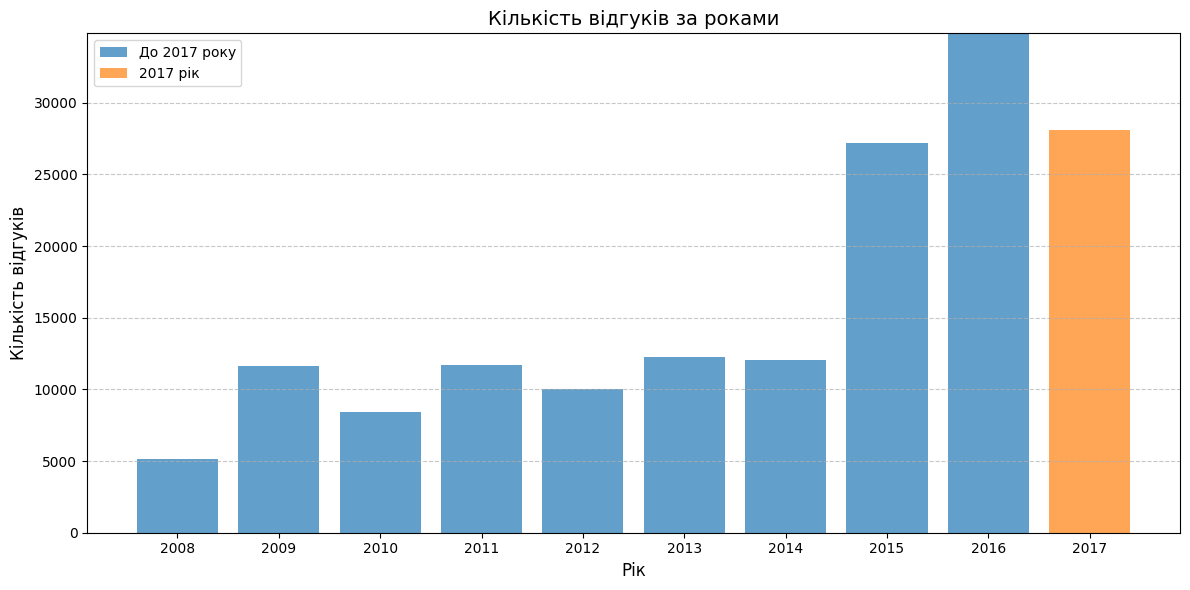

In [ ]:
# Обчислення кількості відгуків за кожен рік
df_until_2017 = pd.read_csv(file_until_2017, parse_dates=['date'], date_parser=lambda x: pd.to_datetime(x, format='%d-%b-%y'))
reviews_per_year_until_2017 = df_until_2017['date'].dt.year.value_counts().sort_index()
reviews_per_year_2017 = df_2017['date'].dt.year.value_counts().sort_index()

# Підготовка даних для графіка
years = range(2008, 2018)  # Роки з 2008 до 2017
reviews_until_2017 = [reviews_per_year_until_2017.get(year, 0) for year in years]
reviews_2017 = [reviews_per_year_2017.get(year, 0) for year in years]

# Побудова графіка
plt.figure(figsize=(12, 6))
plt.bar(years, reviews_until_2017, label='До 2017 року', alpha=0.7)
plt.bar(years, reviews_2017, label='2017 рік', alpha=0.7, bottom=reviews_until_2017)

# Налаштування графіка
plt.title('Кількість відгуків за роками', fontsize=14)
plt.xlabel('Рік', fontsize=12)
plt.ylabel('Кількість відгуків', fontsize=12)
plt.xticks(years)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Відображення графіка
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

# Розділення датасету на тренувальні (train) та валідаційні (validation) дані
X_train, X_val, y_train, y_val = train_test_split(
    df.index.values,  # Індекси рядків як вхідні дані
    df['rating'].values,  # Цільові мітки (рейтинги)
    test_size=0.15,  # Розмір валідаційної вибірки (15% від загального датасету)
    random_state=42,  # Встановлення насіння для відтворюваності
    stratify=df['rating'].values  # Стратифіковане розділення для збереження пропорцій класів
)

# Додавання нового стовпця для позначення типу даних (train/val)
df['data_type'] = ['not_set'] * df.shape[0]  # Початково всі рядки позначені як 'not_set'

# Виведення перших рядків для перевірки змін
df.head()

# Призначення типу даних для тренувальних зразків
df.loc[X_train, 'data_type'] = 'train'

# Призначення типу даних для валідаційних зразків
df.loc[X_val, 'data_type'] = 'val'

# Групування даних за категоріями рейтингу та типами даних (train/val) для підрахунку кількості зразків
df.groupby(['rating', 'data_type']).count()

review  date
rating data_type              
0      train        5332  5332
       val           941   941
1      train        1246  1246
       val           220   220
2      train        1922  1922
       val           339   339

In [ ]:
"""# 3. Loading Tokenizer and Encoding our Data"""

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

# Завантаження токенізатора BERT із попередньо навченими вагами
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',  # Використання нижнього регістру (uncased) для моделі
    do_lower_case=True  # Перетворення всіх символів на нижній регістр
)

# Токенізація та кодування тренувальних даних
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type == 'train'].review.values,  # Текстові дані для тренування
    add_special_tokens=True,  # Додавання спеціальних токенів (наприклад, [CLS] і [SEP])
    return_attention_mask=True,  # Повернення маски уваги для моделі
    pad_to_max_length=True,  # Додавання заповнення до максимального розміру
    max_length=256,  # Максимальна довжина послідовності
    return_tensors='pt'  # Повернення результатів як тензорів PyTorch
)

# Токенізація та кодування валідаційних даних
encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type == 'val'].review.values,  # Текстові дані для валідації
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

# Токенізація та кодування тестових даних за 2017 рік
encoded_data_test_2017 = tokenizer.batch_encode_plus(
    df_2017.review.values,  # Текстові дані для тестування
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

# Підготовка тензорів для тренувальних даних
input_ids_train = encoded_data_train['input_ids']  # Ідентифікатори токенів
attention_masks_train = encoded_data_train['attention_mask']  # Маски уваги
labels_train = torch.tensor(df[df.data_type == 'train'].rating.values)  # Мітки (рейтинги)

# Підготовка тензорів для валідаційних даних
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type == 'val'].rating.values)

# Підготовка тензорів для тестових даних за 2017 рік
input_ids_test_2017 = encoded_data_test_2017['input_ids']
attention_masks_test_2017 = encoded_data_test_2017['attention_mask']
labels_test_2017 = torch.tensor(df_2017['rating'].values)

# Створення об'єктів TensorDataset для зберігання даних
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)  # Тренувальні дані
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)  # Валідаційні дані
dataset_test_2017 = TensorDataset(input_ids_test_2017, attention_masks_test_2017, labels_test_2017)  # Тестові дані

# Розмір тренувального датасету
len(dataset_train)

# Перегляд структури тензорів у валідаційному датасеті
dataset_val.tensors

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad

(tensor([[  101,  1000,  1045,  ...,     0,     0,     0],
         [  101,  1000, 11113,  ...,     0,     0,     0],
         [  101,  1000,  3500,  ...,     0,     0,     0],
         ...,
         [  101,  1000,  1045,  ...,     0,     0,     0],
         [  101,  1000,  2023,  ...,     0,     0,     0],
         [  101,  1000,  1045,  ...,     0,     0,     0]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([1, 0, 0,  ..., 0, 2, 1]))

In [ ]:
"""# 4. Setting up BERT Pretrained Model"""

from transformers import BertForSequenceClassification

# Ініціалізація попередньо навченої моделі BERT для завдання класифікації
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',  # Модель BERT без врахування регістру символів
    num_labels=len(label_dict),  # Кількість вихідних класів (відповідає кількості категорій рейтингу)
    output_attentions=False,  # Вимкнення виходу уваги (attention) для економії ресурсів
    output_hidden_states=False  # Вимкнення прихованих станів для спрощення
)

"""# 5. Creating Data Loaders"""

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Розмір батчу для тренувальних даних
batch_size = 4

# DataLoader для тренувальних даних
dataloader_train = DataLoader(
    dataset_train,  # Тренувальний датасет
    sampler=RandomSampler(dataset_train),  # Випадкова вибірка для батчів
    batch_size=batch_size  # Кількість зразків у кожному батчі
)

# DataLoader для валідаційних даних
dataloader_val = DataLoader(
    dataset_val,  # Валідаційний датасет
    sampler=SequentialSampler(dataset_val),  # Послідовна вибірка (дані не перемішуються)
    batch_size=32  # Розмір батчу для валідаційних даних
)

# DataLoader для тестових даних за 2017 рік
dataloader_test_2017 = DataLoader(
    dataset_test_2017,  # Тестовий датасет
    sampler=SequentialSampler(dataset_test_2017),  # Послідовна вибірка для тестових даних
    batch_size=32  # Розмір батчу для тестових даних
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
"""# 6. Setting Up Optimizer and Scheduler"""

from transformers import AdamW, get_linear_schedule_with_warmup

# Налаштування оптимізатора AdamW
optimizer = AdamW(
    model.parameters(),  # Передаємо параметри моделі
    lr=1e-5,  # Швидкість навчання (learning rate)
    eps=1e-8  # Малий додаток для стабільності обчислень
)

# Кількість епох для навчання
epochs = 5

# Налаштування шедулера для поступового зниження швидкості навчання
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,  # Кількість кроків для розігріву (warm-up)
    num_training_steps=len(dataloader_train) * epochs  # Загальна кількість тренувальних кроків
)

"""# 7. Defining our Performance Metrics"""

import numpy as np
from sklearn.metrics import f1_score

# Функція для обчислення F1-метрики
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()  # Перетворення передбачень у класи
    labels_flat = labels.flatten()  # Перетворення істинних міток
    return f1_score(labels_flat, preds_flat, average='weighted')  # Обчислення F1 зваженого середнього

# Функція для обчислення точності (accuracy) по кожному класу
def accuracy_per_class(preds, labels):
    # Зворотне відображення словника для інтерпретації результатів
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()  # Передбачені класи
    labels_flat = labels.flatten()  # Істинні мітки

    # Перебір унікальних класів
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat == label]  # Передбачення для поточного класу
        y_true = labels_flat[labels_flat == label]  # Істинні значення для поточного класу
        correct = len(y_preds[y_preds == label])  # Кількість правильних передбачень
        total = len(y_true)  # Загальна кількість зразків цього класу
        accuracy = correct / total if total > 0 else 0  # Обчислення точності
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {correct}/{total} ({accuracy:.2f})\n')

"""# 8. Creating our Training Loop"""

import random

# Встановлення насіння для забезпечення відтворюваності результатів
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Визначення пристрою для обчислень (CUDA або CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)  # Передача моделі на обраний пристрій
print(f'Using device: {device}')

# Функція для оцінки моделі на валідаційних даних
def evaluate(dataloader_val):
    model.eval()  # Перехід моделі у режим оцінювання

    loss_val_total = 0  # Сума втрат на валідаційних даних
    predictions, true_vals = [], []  # Зберігання передбачень та істинних міток

    for batch in tqdm(dataloader_val, desc="Evaluating", leave=False):
        batch = tuple(b.to(device) for b in batch)  # Передача батчу на пристрій

        # Підготовка даних для моделі
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2],
        }

        with torch.no_grad():  # Вимкнення обчислення градієнтів для оцінювання
            outputs = model(**inputs)

        # Отримання збитків і логітів (ймовірностей класів)
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()  # Перенос на CPU
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total / len(dataloader_val)  # Середні втрати на валідаційних даних

    predictions = np.concatenate(predictions, axis=0)  # Об'єднання всіх передбачень
    true_vals = np.concatenate(true_vals, axis=0)  # Об'єднання істинних значень

    return loss_val_avg, predictions, true_vals

# Цикл тренування моделі
for epoch in tqdm(range(1, epochs + 1), desc="Epochs"):
    model.train()  # Перехід моделі в режим тренування
    loss_train_total = 0  # Сума втрат на тренувальних даних

    progress_bar = tqdm(dataloader_train, desc=f'Epoch {epoch}', leave=False, disable=False)

    for batch in progress_bar:
        model.zero_grad()  # Обнулення градієнтів
        batch = tuple(b.to(device) for b in batch)  # Передача батчу на пристрій
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }

        outputs = model(**inputs)  # Передбачення моделі
        loss = outputs[0]  # Втрати
        loss_train_total += loss.item()  # Додавання втрат до загальної суми
        loss.backward()  # Зворотнє поширення градієнтів

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Обрізка градієнтів для стабільності

        optimizer.step()  # Оновлення параметрів моделі
        scheduler.step()  # Оновлення швидкості навчання

        progress_bar.set_postfix({'training_loss': f'{loss.item():.3f}'})  # Відображення втрат

    tqdm.write(f'\nEpoch {epoch}')
    loss_train_avg = loss_train_total / len(dataloader_train)  # Середні втрати на тренуванні
    tqdm.write(f'Training loss: {loss_train_avg}')

    # Оцінка на валідаційних даних
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')

    # Оцінка на тестових даних за 2017 рік
    test_loss, test_predictions, test_true_vals = evaluate(dataloader_test_2017)
    test_f1 = f1_score_func(test_predictions, test_true_vals)
    tqdm.write(f'Test loss (2017): {test_loss}')
    tqdm.write(f'F1 Score (weighted) on Test (2017): {test_f1}')

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Using device: cuda


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2125 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.6771054581456325


Evaluating:   0%|          | 0/47 [00:00<?, ?it/s]

Validation loss: 0.5618908332383379
F1 Score (weighted): 0.8551011060677809


Evaluating:   0%|          | 0/878 [00:00<?, ?it/s]

Test loss (2017): 0.6084934024135996
F1 Score (weighted) on Test (2017): 0.8407099115498277


Epoch 2:   0%|          | 0/2125 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.5298925413174883


Evaluating:   0%|          | 0/47 [00:00<?, ?it/s]

Validation loss: 0.6783936603906306
F1 Score (weighted): 0.8691612079771808


Evaluating:   0%|          | 0/878 [00:00<?, ?it/s]

Test loss (2017): 0.7670659747882693
F1 Score (weighted) on Test (2017): 0.8466084491774435


Epoch 3:   0%|          | 0/2125 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.4066163919984418


Evaluating:   0%|          | 0/47 [00:00<?, ?it/s]

Validation loss: 0.9384054760349557
F1 Score (weighted): 0.864934292997451


Evaluating:   0%|          | 0/878 [00:00<?, ?it/s]

Test loss (2017): 1.0944827248794207
F1 Score (weighted) on Test (2017): 0.830993620168105


Epoch 4:   0%|          | 0/2125 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.28737695328524226


Evaluating:   0%|          | 0/47 [00:00<?, ?it/s]

Validation loss: 1.150691934722535
F1 Score (weighted): 0.8628335236517535


Evaluating:   0%|          | 0/878 [00:00<?, ?it/s]

Test loss (2017): 1.2719712705268675
F1 Score (weighted) on Test (2017): 0.8371431370311692


Epoch 5:   0%|          | 0/2125 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.22036229639423682


Evaluating:   0%|          | 0/47 [00:00<?, ?it/s]

Validation loss: 1.2662030325291005
F1 Score (weighted): 0.8561524671868913


Evaluating:   0%|          | 0/878 [00:00<?, ?it/s]

Test loss (2017): 1.374557225317917
F1 Score (weighted) on Test (2017): 0.836959605461194
